<h1>Handwriting Letter GAN Usage</h1>

<h3>Links</h3>
<ul>
    <li><a href=https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/>cGAN Code</a></li>
    <li><a href=https://keras.io/getting-started/functional-api-guide/>Keras Functional API</a></li>
    <li><a href=<li><a href=https://arxiv.org/pdf/1702.05373.pdf>EMNIST Dataset Paper</a></li>
</ul>

In [24]:
import numpy as np
from numpy.random import *
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt

# !rm -r Handwriting-GAN
!git clone https://github.com/Amogh13246831/Handwriting-GAN
!ls

fatal: destination path 'Handwriting-GAN' already exists and is not an empty directory.
Handwriting-GAN  sample_data


In [0]:
def generate_latent_noise(latent_dim, n_samples, n_classes=66):
    xin = randn(latent_dim * n_samples)
    xin = xin.reshape(n_samples, latent_dim)
    labels = randint(0, n_classes, n_samples)  #  generator class label
    return xin, labels

In [26]:
gen_letter = load_model('Handwriting-GAN/models/generator_byclass.h5')
gen_punc = load_model('Handwriting-GAN/models/generator_punc.h5')

latent_dim_letter = gen_letter.input[0].shape[1]
latent_dim_punc = gen_punc.input[0].shape[1]

gen_letter.summary()
gen_punc.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 6272)         633472      input_8[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        3100        input_7[0][0]                    
____________________________________________________________________________________________

In [0]:
def get_emnist_byclass_dict():
  byclass_dict = {chr(i): i-48 for i in range(48, 58)}
  byclass_dict.update({chr(i): i-55 for i in range(65, 91)})
  byclass_dict.update({chr(i): i-61 for i in range(97, 123)})
  return byclass_dict

def get_punc_dict(punc_string):
  punc_dict = {punc[i]: i for i in range(len(punc))}
  return punc_dict

def increase_contrast(image):
  for i in range(len(image)):
    for j in range(len(image[0])):
      if image[i][j] > 0.1:
        image[i][j] = 0.9
      else:
        image[i][j] = 0.
  return image

def generate_word_images(word, latent_dim_letter, latent_dim_punc, letter_dict, punc_dict):
  labels = [] 
  is_punc = [False] * len(word) 

  for c in range(len(word)):
    if word[c] in letter_dict.keys():
      labels.append(letter_dict[word[c]])
    elif word[c] in punc_dict.keys():
      is_punc[c] = True
      labels.append(punc_dict[word[c]])
    else:
      raise Exception("Invalid Character")

  images = []
  for i in range(len(labels)):
    if is_punc[i]:
      noise, _ = generate_latent_noise(latent_dim_punc, 1)
      images.append(gen_punc.predict([noise, np.asarray([labels[i]])]))
    else:
      noise, _ = generate_latent_noise(latent_dim_letter, 1)
      images.append(gen_letter.predict([noise, np.asarray([labels[i]])]))

  images = np.squeeze(np.asarray(images))
  if images.ndim == 2:    # for a single-letter image, consistency of shape
    images = np.asarray([images])
  images = (images + 1) / 2.0

  for i in range(len(images)):
    if is_punc[i]:
      images[i] = increase_contrast(images[i])

  return images, is_punc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


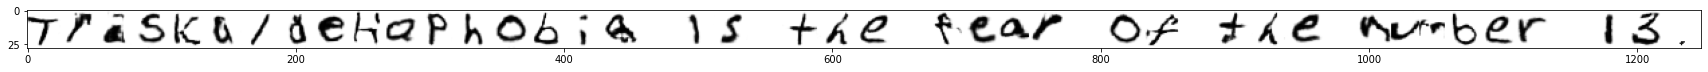

In [75]:
def chop_wsp(image, thresh=0.1):
  ncr = len(image[0]) - 3
  while np.all(image[:][ncr] < thresh): # chop from right
    ncr -= 1
  ncl = 3
  while np.all(image[:][ncl] < thresh): # chop from left
    ncl += 1
  return image[:, (ncl-3):(ncr+3)]

def get_word(letters, is_punc, thresh=0.1):
  return np.hstack((letters[i] if is_punc[i] else chop_wsp(letters[i]) for i in range(len(letters))))

def get_wspace(height, base_width, variance):
  ws = np.zeros((height, base_width + randint(-variance, variance)))
  return ws

def get_sentence(sentence, latent_dim_letter, latent_dim_punc, letter_dict, punc_dict, thresh=0.1, wsh=28, wsw=30, wsv=5):
  words = sentence.split(' ')
  letter_imgs = [generate_word_images(w, latent_dim_letter, latent_dim_punc, letter_dict, punc_dict) for w in words]
  word_imgs = [get_word(letter_imgs[i][0], letter_imgs[i][1]) for i in range(len(letter_imgs))]
  sentence = word_imgs[0]
  for img in word_imgs[1:]:
    sentence = np.hstack((sentence, get_wspace(wsh, wsw, wsv), img))
  return sentence

letter_dict = get_emnist_byclass_dict()
punc = "!,.?"
punc_dict = get_punc_dict(punc)

sentence = 'Triskaidekaphobia is the fear of the number 13.'

fig = plt.figure(figsize=(30, 2))
plt.imshow(get_sentence(sentence, latent_dim_letter, latent_dim_punc, letter_dict, punc_dict), cmap='gray_r')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


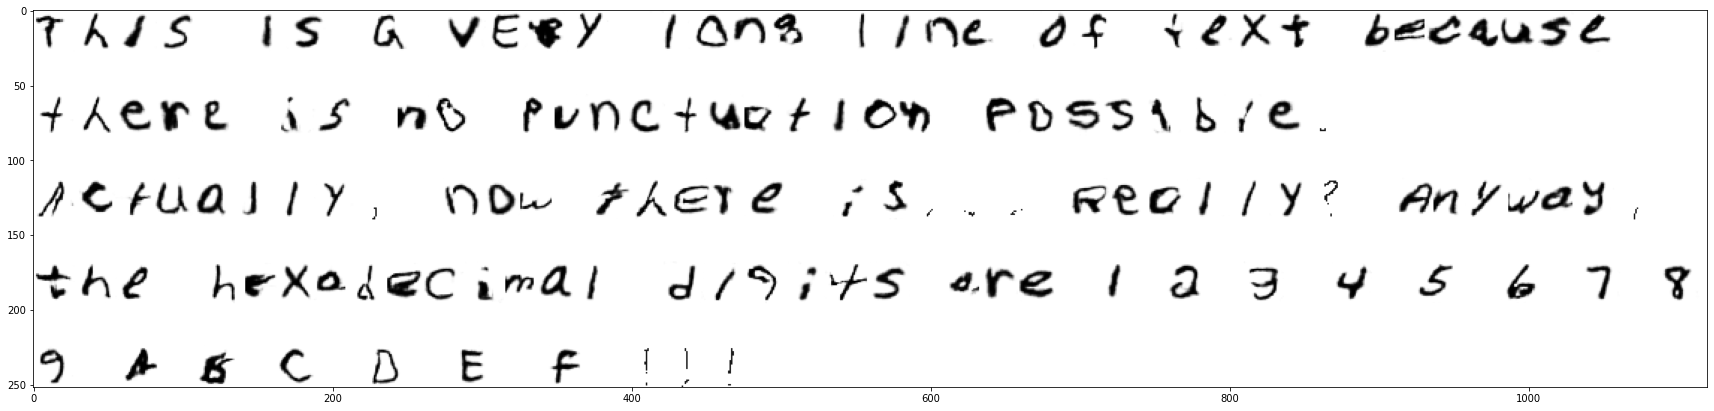

In [82]:
def get_text_lines(text, line_nchars, char_width, char_height, latent_dim_letter, latent_dim_punc, letter_dict, punc_dict):
  words = text.split(' ')
  letter_imgs = [generate_word_images(w, latent_dim_letter, latent_dim_punc, letter_dict, punc_dict) for w in words]
  word_imgs = [get_word(letter_imgs[i][0], letter_imgs[i][1]) for i in range(len(letter_imgs))]

  page = []
  line_width = line_nchars * char_width
  line = word_imgs[0]  
  current_word = 1
  while current_word < len(word_imgs):
    ws = get_wspace(char_height, char_width, int(0.2*char_width))
    img = word_imgs[current_word]

    if len(line[0]) + len(ws[0]) + len(img[0]) <= line_width: # fits in a line
      line = np.hstack((line, ws, img))
    else:
      line = np.hstack((line, np.zeros((char_height, line_width-len(line[0])))))  # complete the length
      page.append(np.copy(line))
      page.append(np.zeros((char_width, line_width))) # space between lines
      line = word_imgs[current_word]  # next line 

    current_word += 1

  line = np.hstack((line, np.zeros((char_height, line_width-len(line[0])))))  # last line
  page.append(line)

  text_lines = np.vstack(page)
  return text_lines
  
text = 'This is a VERY long line of text because there is no punctuation possible. Actually, now there is... Really? Anyway, the hexadecimal digits are 1 2 3 4 5 6 7 8 9 A B C D E F !!!'

tl = get_text_lines(text, 40, 28, 28, latent_dim_letter, latent_dim_punc, letter_dict, punc_dict)
tl.shape

fig = plt.figure(figsize=(30, 20))
plt.imshow(tl, cmap = 'gray_r')